# 1. 心律不齐分类
## 1.1 参考资料
* Keras：Conv1D：https://blog.csdn.net/VeritasCN/article/details/90050584
* 深度学习模型系列(1) | VGG16 Keras实现:https://cloud.tencent.com/developer/article/1509047
* ECGAI_1D-CNN:https://github.com/SEU-wzx/ECGAI_1D-CNN
* Keras 自编码器AutoEncoder（五）:https://blog.csdn.net/qq_19707521/article/details/78740986
* 关于keras模型拆装：https://tensorflow.google.cn/guide/keras/save_and_serialize?hl=zh-cn
* SENet：https://www.cnblogs.com/bonelee/p/9030092.html
* Keras实现Senet block模块:https://blog.csdn.net/sinat_36618660/article/details/102546146

# 2. 实现

In [1]:
import os
import seaborn as sns
import collections
import numpy as np
import scipy.io as scio

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input,\
BatchNormalization,Multiply,Layer,GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.activations as activations
import tensorflow.keras.layers as layers

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## 2.1 数据读取

In [2]:
dataset = np.loadtxt('data/X.csv',delimiter=',')
label = np.loadtxt('data/Y.csv',delimiter=',',dtype='int')
label = np.eye(7)[label]

In [3]:
# Variables
classes = ['1','2','3','4','5','6','0']
ClassesNum = len(classes)
        
# list -> arr
X=np.array(dataset)
Y=np.array(label)


# 分层抽样
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8,random_state=0)
sss.get_n_splits(X, Y)
for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

# get X_train, X_test, y_train, y_test 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# X_train, X_val, y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
# print("shape of X_val : ", np.shape(X_val))
# print("shape of y_val : ", np.shape(y_val))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

TRAIN: [5774 3846 3057 ... 7567 5792 1675] TEST: [1013 1673 2862 ... 6989 8021 1745]
X_train :  6624
X_test  :  1656
shape of X_train :  (3600,)
shape of y_train :  (6624, 7)
shape of X_test :  (1656, 3600)
shape of y_test :  (1656, 7)


## 2.2 卷积降噪自编码器训练

In [6]:
# 为原数据加入噪声
## 噪声影响程度
factor = 0.05
np.random.seed(123)
noise = np.random.randn(len(X_train),len(X_train[0]))*factor
X_train += noise

# 定义SEBlock
## reduction 用来降维
def SEBlock(inputs,reduction=4,if_train=True):
    x = GlobalAveragePooling1D()(inputs)
    x = Dense(int(x.shape[-1]) // reduction, use_bias=False,activation=activations.relu,trainable=if_train)(x)
    x = Dense(int(inputs.shape[-1]), use_bias=False,activation=activations.hard_sigmoid,trainable=if_train)(x)
    return Multiply()([inputs,x])


# 定义卷积降噪自编码器
def conv_autoencoder(input_ecg):
    x = layers.Conv1D(filters = 16, kernel_size = 3,padding='same',name='encoder_1')(input_ecg)
    x = BatchNormalization(trainable=False)(x)
    x = Activation('relu')(x)  
    x = layers.MaxPool1D(pool_size = 2, padding='same',name='encoder_2')(x)
    encoded = SEBlock(x)
    
    x = layers.Conv1D(filters = 8, kernel_size = 3, activation='relu', padding='same',name='decoder_1')(encoded)
    x = layers.Conv1D(filters = 16, kernel_size = 3, activation='relu', padding='same',name='decoder_3')(x)
    x = layers.UpSampling1D(size = 2,name='decoder_4')(x)  
    decoded = layers.Conv1D(filters = 1, kernel_size = 3, activation='sigmoid', padding='same',name='decoder_5')(x)

    autoencoder = Model(inputs=input_ecg, outputs=decoded)
    
    return autoencoder

input_ecg = Input(shape=(3600,1))
autoencoder = conv_autoencoder(input_ecg = input_ecg)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')  

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3600, 1)]    0                                            
__________________________________________________________________________________________________
encoder_1 (Conv1D)              (None, 3600, 16)     64          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 3600, 16)     64          encoder_1[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 3600, 16)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.reshape(X_test, (np.shape(X_test)[0], np.shape(X_test)[1], 1))
# 训练降噪自编码器
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  
  
# 打开一个终端并启动TensorBoard，终端中输入 tensorboard --logdir=/autoencoder  
# autoencoder.fit(X_train, X_train, epochs=2, batch_size=32,  shuffle=True) 

## 2.3 混合模型定义

#### 加载降噪自编码器

In [16]:
def vgg19_heart(input_data,classes=7):
    
    x = layers.Conv1D(filters = 128, kernel_size = 3,padding='same',name='encoder_1')(input_ecg)
    x = BatchNormalization(trainable=False)(x)
    x = Activation('relu')(x)  
    x = layers.MaxPool1D(pool_size = 2, padding='same',name='encoder_2')(x)
    x = SEBlock(x)
    x = layers.Conv1D(filters = 64, kernel_size = 3,padding='same',name='encoder_3')(x)
    x = BatchNormalization(trainable=False)(x)
    x = Activation('relu')(x)  
    x = layers.MaxPool1D(pool_size = 2, padding='same',name='encoder_4')(x)
    x = SEBlock(x)
    
    # Block2
    x = layers.Conv1D(filters = 64,kernel_size = 3,padding='same',name='block2_conv1',activation='relu')(x)
    x = layers.Conv1D(filters = 64,kernel_size = 3,padding='same',name='block2_conv2',activation='relu')(x)
    x = SEBlock(x)
    x = layers.MaxPool1D(pool_size=2,strides=2,name='block2_pool')(x)
    
    x = layers.Conv1D(filters = 128,kernel_size = 3,padding='same',name='block3_conv1',activation='relu')(x)
    x = layers.MaxPool1D(pool_size=2,strides=2,name='block3_pool_1')(x)
    x = layers.Conv1D(filters = 128,kernel_size = 3,padding='same',name='block3_conv2',activation='relu')(x)
    x = layers.MaxPool1D(pool_size=2,strides=2,name='block3_pool_2')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    
    model = Model(input_data,x,name='VGG19-Heart')
    
    return model

In [17]:
model = vgg19_heart(input_data=input_ecg,classes=ClassesNum)
print(model.summary())
# for i in range(1,9):
#     model.layers[i].set_weights(autoencoder.layers[i].get_weights())

Model: "VGG19-Heart"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3600, 1)]    0                                            
__________________________________________________________________________________________________
encoder_1 (Conv1D)              (None, 3600, 128)    512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 3600, 128)    512         encoder_1[0][0]                  
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 3600, 128)    0           batch_normalization_5[0][0]      
________________________________________________________________________________________

In [18]:
# setting optimizers & compile
optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
# model_all.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# expand X_train dims
# Y : int -> binary (one-hot)
# y_train = to_categorical(y_train,num_classes = ClassesNum)
# y_test = to_categorical(y_test,num_classes = ClassesNum)

display(np.shape(X_train))

(6624, 3600, 1)

In [5]:
# 加载模型
model = load_model('model.h5')

In [19]:
BATCH_SIZE = 16
EPOCHS = 100
# history = model_all.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS)
history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,validation_split=0.2)

Epoch 1/100
332/332 [==============================] - 115s 348ms/step - loss: 0.9681 - accuracy: 0.7390 - val_loss: 0.8038 - val_accuracy: 0.7313
Epoch 2/100
332/332 [==============================] - 126s 381ms/step - loss: 0.6401 - accuracy: 0.7992 - val_loss: 0.4906 - val_accuracy: 0.8611
Epoch 3/100
332/332 [==============================] - 126s 380ms/step - loss: 0.4066 - accuracy: 0.8817 - val_loss: 0.4164 - val_accuracy: 0.8898
Epoch 4/100
332/332 [==============================] - 123s 370ms/step - loss: 0.3030 - accuracy: 0.9053 - val_loss: 0.3753 - val_accuracy: 0.9034
Epoch 5/100
332/332 [==============================] - 129s 389ms/step - loss: 0.2425 - accuracy: 0.9239 - val_loss: 0.4021 - val_accuracy: 0.9094
Epoch 6/100
332/332 [==============================] - 121s 364ms/step - loss: 0.1913 - accuracy: 0.9358 - val_loss: 0.4141 - val_accuracy: 0.9034
Epoch 7/100
332/332 [==============================] - 121s 365ms/step - loss: 0.1508 - accuracy: 0.9513 - val_loss: 0

332/332 [==============================] - 122s 367ms/step - loss: 0.0250 - accuracy: 0.9936 - val_loss: 0.9525 - val_accuracy: 0.9140
Epoch 57/100
332/332 [==============================] - 121s 365ms/step - loss: 0.0159 - accuracy: 0.9947 - val_loss: 1.1537 - val_accuracy: 0.9208
Epoch 58/100
332/332 [==============================] - 121s 365ms/step - loss: 0.0177 - accuracy: 0.9947 - val_loss: 0.9119 - val_accuracy: 0.9200
Epoch 59/100
332/332 [==============================] - 123s 369ms/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 1.0476 - val_accuracy: 0.9200
Epoch 60/100
 56/332 [====>.........................] - ETA: 1:48 - loss: 0.0213 - accuracy: 0.9944

KeyboardInterrupt: 

In [40]:
model.save('./model.h5')

In [71]:
# val_loss_acc = model_all.evaluate(X_test, y_test, batch_size=100)
val_loss_acc = model.evaluate(X_test, y_test, batch_size = 16)
print("loss of val : ", val_loss_acc[0])
print("acc of val : ", val_loss_acc[1])

166/166 [==============================] - 2s 10ms/step - loss: 0.4967 - accuracy: 0.9079
loss of val :  0.4967125654220581
acc of val :  0.9079245328903198


结果可视化

In [56]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [57]:
predictions = model.predict(X_test)
print(predictions)

[[6.0328348e-03 9.9301237e-01 9.4439543e-04 ... 1.0297632e-05
  1.4912478e-12 7.1791355e-08]
 [1.7696004e-07 9.9868613e-01 1.7616973e-04 ... 1.1261554e-03
  1.0670851e-05 2.7295914e-07]
 [3.8413259e-06 2.0688849e-03 2.3894283e-05 ... 2.3359444e-08
  9.9790335e-01 2.8905253e-16]
 ...
 [2.6814723e-06 9.0382707e-01 6.3994676e-03 ... 8.9705147e-02
  3.1953929e-05 2.5532612e-05]
 [1.6886381e-03 9.9400842e-01 2.5240013e-03 ... 1.7757314e-03
  4.8706870e-08 3.1829595e-06]
 [1.7659280e-08 9.9972790e-01 1.2425847e-05 ... 1.6486937e-04
  9.1883332e-05 3.9440572e-08]]


In [58]:
y_pre = np.zeros((int(predictions.size/predictions[0].size),predictions[0].size))
for i in range(len(predictions)):
    y_pre[i][np.where(predictions[i]==max(predictions[i]))[0][0]]=1
print(y_pre[0])

[0. 1. 0. 0. 0. 0. 0.]


In [59]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.jet):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 显示混淆矩阵
def plot_confuse(model, x_val, y_val):
    predictions = model.predict(x_val)
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=predictions)
    plt.figure()
    plot_confusion_matrix(conf_mat, range(np.max(truelabel)+1))

<AxesSubplot:>

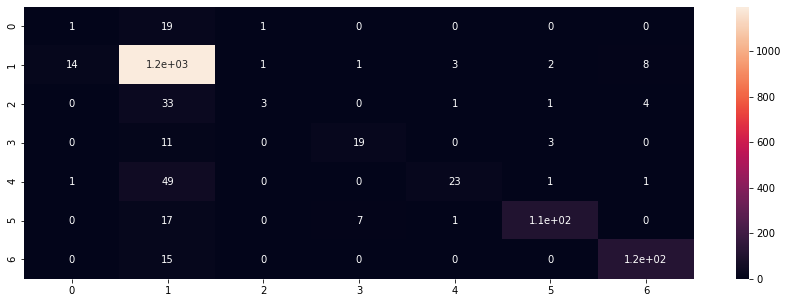

In [60]:
pre_label = y_pre.argmax(axis=-1)
test_label = y_test.argmax(axis=-1)
conf_mat = confusion_matrix(y_true=test_label,y_pred=pre_label)
sns.heatmap(conf_mat,annot=True)